# Chapter 2 - Model Selection and Training
Guilherme de Oliveira <br>
8/30/2016

## Introduction

In Chapter 2 we will work on the classification model of the US Census data that was analyzed in Chapter 1. My biggest interest in modelling will be dealing with the class imbalance of the target variable. In particular, I am interested in the following aspects:
<ul>
<li> How best to assess the accuracy of the classifier. It is unlikely that accuracy will suffice, because of the [accuracy paradox](https://en.wikipedia.org/wiki/Accuracy_paradox).
<li> What are some approaches that we can use to deal with the class imbalance? Examples include oversampling, undersampling, incorporating clustering algorithms, etc...
</ul>
<br>
<br>
<br>
# This is a work in progress. Stay tuned for more...
<br>
<br>
<br>


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

## Preprocessing Data

In [2]:
# preprocessing function

def preprocessData(file_name):
    # columns stores tuples of (column_name, continuous/nominal/target, prefix for dummy encoding)
    the_columns  = [('age', 'continuous'), 
            ('class_of_worker', 'nominal'), 
            ('detailed_industry_code', 'nominal'), 
            ('detailed_occupation_code', 'nominal'), 
            ('education', 'nominal'), 
            ('wage_per_hour', 'continuous'), 
            ('enrolled_in_edu_last_week', 'nominal'),
            ('marital_status', 'nominal'),
            ('major_industry_code', 'nominal'),
            ('major_occupation_code', 'nominal'),
            ('race', 'nominal'),
            ('hispanic_origin', 'nominal'),
            ('sex', 'binary'), # binary column with values Male/Female
            ('member_of_labor_union', 'nominal'), 
            ('reason_for_unemployment', 'nominal'),
            ('full_or_part_time_employment_stat', 'nominal'),
            ('capital_gains', 'continuous'),
            ('capital_losses', 'continuous'),
            ('dividends', 'continuous'),
            ('tax_filer', 'nominal'),
            ('region_of_previous_residence', 'nominal'),
            ('state_of_previous_residence', 'nominal'),
            ('detailed_household_family_stat', 'nominal'),
            ('detailed_household_summary', 'nominal'),
            ('instance_weight', 'IGNORE'), # as per instructions, to be dropped
            ('migration_code_change_in_msa', 'nominal'),
            ('migration_code_change_in_reg', 'nominal'),
            ('migration_code_move_within_reg', 'nominal'),
            ('live_in_this_house_1_yr_ago', 'nominal'),
            ('migration_prev_res_in_sunbelt', 'nominal'),
            ('num_persons_worked_for_employer', 'continuous'),
            ('family_members_under_18', 'nominal'),
            ('cob_father', 'nominal'),
            ('cob_mother', 'nominal'),
            ('cob_self', 'nominal'),
            ('citizenship', 'nominal'),
            ('own_business_or_self_employed', 'nominal'),
            ('fill_in_questionnaire_for_veterans_admin', 'nominal'),
            ('veterans_benefits', 'nominal'),
            ('weeks_worked_in_year', 'nominal'),
            ('year', 'nominal'), 
            ('savings','target')] # binary TARGET variable
    
    raw_data = pd.read_csv(file_name, names=[c[0] for c in the_columns], index_col=False)
    original_shape = raw_data.shape
    
    raw_data.drop('instance_weight', axis=1, inplace=True)
    the_columns.remove(('instance_weight', 'IGNORE'))
    
    # find the duplicate rows, keep the first one
    duplicate_rows = raw_data.duplicated(keep='first')
    
    print 'number of duplicates = {:d}'.format(duplicate_rows.sum())
    raw_data = raw_data.drop_duplicates(keep='first')
    new_shape =  raw_data.shape
    print 'number of duplicates removed = {:d}'.format(original_shape[0] - new_shape[0])
    print 'original shape = {:d}, {:d}'.format(original_shape[0], original_shape[1])
    print 'new shape = {:d}, {:d}'.format(raw_data.shape[0], raw_data.shape[1])
    
    # convert nominal columns (object dtype) to integer type
    data = pd.DataFrame(raw_data.select_dtypes(include=['object']))
    object_columns = data.columns
    
    for column in object_columns:
        unique_values = data[column].unique()
        dictionary = {key:idx for idx,key in enumerate(unique_values)}
        data[column] = data[column].apply(lambda x : dictionary[x])
    
    # add nominal columns that were already in integer format 
    nominal_integer_columns = [c[0] for c in the_columns if c[1] == 'nominal' and c[0] not in data.columns]
    data[nominal_integer_columns] = raw_data[nominal_integer_columns]
    
    # convert 'sex', and 'savings' columns to binary; add year column
    data['savings'] = raw_data['savings'].map(lambda x: 1 if str(x).strip() == '50000+.' else 0)
    data['sex'] = raw_data['sex'].map(lambda x: 1 if str(x).strip() == 'Male' else 0)
    data['year'] = raw_data['year']
    
    # add continuous columns
    continuous_columns = [c[0] for c in the_columns if c[1] == 'continuous']
    data[continuous_columns] = raw_data[continuous_columns]
    
    # verify that we aren't missing any columns
    assert set(data.columns) == (set(raw_data.columns))

    print 'The final processed data has {:,d} rows and {:d} columns.\n'.format(data.shape[0], data.shape[1])
    return data


In [3]:
data = preprocessData('us_census_full/census_income_learn.csv')

number of duplicates = 46627
number of duplicates removed = 46627
original shape = 199523, 42
new shape = 152896, 41
The final processed data has 152,896 rows and 41 columns.



In [4]:
data.head(3)

,class_of_worker,education,enrolled_in_edu_last_week,marital_status,major_industry_code,major_occupation_code,race,hispanic_origin,sex,member_of_labor_union,...,own_business_or_self_employed,veterans_benefits,weeks_worked_in_year,year,age,wage_per_hour,capital_gains,capital_losses,dividends,num_persons_worked_for_employer
0,0,0,0,0,0,0,0,0,0,0,...,0,2,0,95,73,0,0,0,0,0
1,1,1,0,1,1,1,0,0,1,0,...,0,2,52,94,58,0,0,0,0,1
2,0,2,1,2,0,0,1,0,0,0,...,0,2,0,95,18,0,0,0,0,0


## Split Data into Training and Test Sets for Cross Validation

In [5]:
# obtain training and test set for cross-validation
X = data.drop('savings', axis=1)
y = data.loc[:,'savings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print 'size of training data: {:7d}, {:3d}'.format(X_train.shape[0], X_train.shape[1])
print 'size of test data:     {:7d}, {:3d}'.format(X_test.shape[0], X_test.shape[1])
print
ytr0, ytr1 = (y_train == 0).sum(), (y_train == 1).sum()
yte0, yte1 = (y_test == 0).sum(), (y_test == 1).sum()
print 'y_train==0: {:6d},  y_train==1: {:4d},  balance: {:.4f}'.format(
    ytr0, ytr1, float(ytr0)/(ytr0+ytr1))
print 'y_test==0:  {:6d},  y_test==1:  {:4d},  balance: {:.4f}'.format(
    yte0, yte1, float(yte0)/(yte0+yte1))
print '\nThe training and test set appear to have the same degree of class imbalance.\n'

size of training data:  107027,  40
size of test data:       45869,  40

y_train==0:  98399,  y_train==1: 8628,  balance: 0.9194
y_test==0:   42130,  y_test==1:  3739,  balance: 0.9185

The training and test set appear to have the same degree of class imbalance.



## Random Forest Model

In [6]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


In [17]:
def print_confusion_matrix(y_true, y_pred):
    header = '\t          prediction 0    prediction 1'
    row0 =   '\tclass 0 {:11,d} {:14,d}'
    row1 =   '\tclass 1 {:11,d} {:14,d}'
    cm = confusion_matrix(y_true, y_pred)
    print
    print header
    print row0.format(cm[0,0], cm[0,1])
    print row1.format(cm[1,0], cm[1,1])
    print
    tp, fn = float(cm[0,0]), float(cm[0,1])
    fp, tn = float(cm[1,0]), float(cm[1,1])
#     print 'precision = {:.4f},  {:.4f}'.format(tp/(tp+fp), tn/(tn+fn))
#     print 'recall =    {:.4f},  {:.4f}'.format(tp/(tp+fn), tn/(tn+fp))
    

    

In [8]:
def run_grid_search_on_random_forest(score=None, print_grid_scores=False):
    
    rf_clf = GridSearchCV(RandomForestClassifier(), 
                          tuned_parameters, 
                          scoring=score)
    
    rf_clf.fit(X_train, y_train)
    y_true, y_pred = y_test, rf_clf.predict(X_test)
    
    print 'Best parameters set found on development set:'
    print rf_clf.best_params_
    print 'Best score = {:.4f}'.format(rf_clf.best_score_)
    if print_grid_scores:
        print '\nGrid scores on development set:\n'
        for params, mean_score, scores in rf_clf.grid_scores_:
            print("%0.4f (+/-%0.04f) for %r"
                  % (mean_score, scores.std() * 2, params))
    print
    print 'confusion matrix'
    print_confusion_matrix(y_true, y_pred)
    print
    print '\nDetailed classification report:\n'
    print classification_report(y_true, y_pred, digits=5)
    print
    return rf_clf

In [9]:
tuned_parameters = {'n_estimators': [20, 40], 
                    'max_depth': [6, None],
                    'max_features' : ['sqrt', 40],
                    'min_samples_split' : [1, 2]}

In [10]:
rf_a = run_grid_search_on_random_forest('accuracy', print_grid_scores=True, verbose=1)

Best parameters set found on development set:
{'max_features': 'sqrt', 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': None}
Best score = 0.9398

Grid scores on development set:

0.9302 (+/-0.0009) for {'max_features': 'sqrt', 'min_samples_split': 1, 'n_estimators': 20, 'max_depth': 6}
0.9294 (+/-0.0020) for {'max_features': 'sqrt', 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': 6}
0.9274 (+/-0.0036) for {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 6}
0.9301 (+/-0.0014) for {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 40, 'max_depth': 6}
0.9353 (+/-0.0011) for {'max_features': 40, 'min_samples_split': 1, 'n_estimators': 20, 'max_depth': 6}
0.9349 (+/-0.0014) for {'max_features': 40, 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': 6}
0.9348 (+/-0.0010) for {'max_features': 40, 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 6}
0.9349 (+/-0.0008) for {'max_features': 40, 'min_samples_split': 2, 

In [11]:
rf_p = run_grid_search_on_random_forest('precision', print_grid_scores=True, verbose=1)

Best parameters set found on development set:
{'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 40, 'max_depth': 6}
Best score = 0.9127

Grid scores on development set:

0.8844 (+/-0.0501) for {'max_features': 'sqrt', 'min_samples_split': 1, 'n_estimators': 20, 'max_depth': 6}
0.8999 (+/-0.0433) for {'max_features': 'sqrt', 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': 6}
0.8843 (+/-0.0329) for {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 6}
0.9127 (+/-0.0234) for {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 40, 'max_depth': 6}
0.7304 (+/-0.0373) for {'max_features': 40, 'min_samples_split': 1, 'n_estimators': 20, 'max_depth': 6}
0.7396 (+/-0.0235) for {'max_features': 40, 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': 6}
0.7333 (+/-0.0230) for {'max_features': 40, 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 6}
0.7284 (+/-0.0226) for {'max_features': 40, 'min_samples_split': 2, 'n_

In [12]:
rf_r = run_grid_search_on_random_forest('recall', print_grid_scores=True, verbose=1)

Best parameters set found on development set:
{'max_features': 40, 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': None}
Best score = 0.4373

Grid scores on development set:

0.1479 (+/-0.0377) for {'max_features': 'sqrt', 'min_samples_split': 1, 'n_estimators': 20, 'max_depth': 6}
0.1588 (+/-0.0232) for {'max_features': 'sqrt', 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': 6}
0.1510 (+/-0.0088) for {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 6}
0.1390 (+/-0.0179) for {'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 40, 'max_depth': 6}
0.3017 (+/-0.0246) for {'max_features': 40, 'min_samples_split': 1, 'n_estimators': 20, 'max_depth': 6}
0.3040 (+/-0.0061) for {'max_features': 40, 'min_samples_split': 1, 'n_estimators': 40, 'max_depth': 6}
0.3034 (+/-0.0189) for {'max_features': 40, 'min_samples_split': 2, 'n_estimators': 20, 'max_depth': 6}
0.3046 (+/-0.0155) for {'max_features': 40, 'min_samples_split': 2, 'n_e

In [21]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

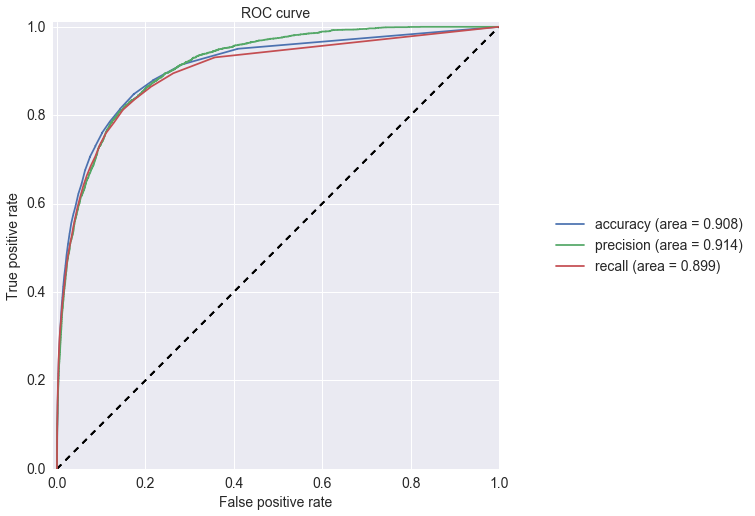

In [69]:
plt.figure(figsize=(8,8))
ax = plt.gca()
fs=14

for rf, label in zip([rf_a, rf_p, rf_r],['accuracy', 'precision', 'recall']):
    probs = rf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    ax.plot([0, 1], [0, 1], 'k--')
    text = ' (area = {:.3f})'.format(roc_auc)
    ax.plot(fpr, tpr, label=label + text)

ax.set_xlabel('False positive rate', fontsize=fs)
ax.set_ylabel('True positive rate', fontsize=fs)
ax.set_title('ROC curve', fontsize=fs)
ax.set_ylim((0,1.01))
ax.set_xlim((-0.01, 1.0))
ax.set_xticks(np.arange(0.0, 1.01, 0.2))
ax.set_xticklabels(np.arange(0.0,1.01,0.2), fontsize=fs)
ax.set_yticks(np.arange(0.0, 1.01, 0.2))
ax.set_yticklabels(np.arange(0.0,1.01,0.2), fontsize=fs)
plt.legend(fontsize=fs, bbox_to_anchor=(1.1,0.5), loc='center left')
plt.show()

## Logistic Regression

## Incorporate Some Feature Engineering
Start with the column "detailed_household_family_stat" and convert the classes that have no savings greater than 50K into one class.

In [ ]:
dhfs = data['detailed_household_family_stat'][data['savings'] == 1].unique()
dhfs.sort()
print 'unique values for savings = 1', dhfs
dhfs_all = data['detailed_household_family_stat'].unique()
dhfs_all.sort()
print 'unique values for all vals   ', dhfs_all

diff = set(dhfs_all).difference(set(dhfs))
print ' the differences are........', diff
if diff is None:
    print '\n diff is empty'
else:
    print ' len(diff)', len(diff)
    val = max(diff) + 1
    print ' mapping values to:', val


In [73]:
def update_column(column):
    dhfs = data[column][data['savings'] == 1].unique()
    dhfs.sort()
    print 'unique values for svngs = 1', dhfs
    dhfs_all = data[column].unique()
    dhfs_all.sort()
    print 'unique values for all vals ', dhfs_all
    
    diff = set(dhfs_all).difference(set(dhfs))
    print ' the differences are........', diff
    if diff is None:
        print '\n diff is empty'
        return data[column]
    
    print ' len(diff)', len(diff)
    
    val = max(diff) + 1
    print ' mapping values to:', val
    return data[column].map(lambda x : val if x in diff else x)


In [74]:
print data['detailed_household_family_stat'][data['savings']==0].value_counts().shape
data['detailed_household_family_stat'] = update_column('detailed_household_family_stat')
print data['detailed_household_family_stat'][data['savings']==0].value_counts().shape


(38,)
unique values for svngs = 1 [ 0  1  2  3  4  5  6  7 10 11 12 15 16 17 18 19 22 28 30]
unique values for all vals  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
 the differences are........ set([32, 33, 34, 35, 36, 37, 8, 9, 13, 14, 20, 21, 23, 24, 25, 26, 27, 29, 31])
 len(diff) 19
 mapping values to: 38
(20,)


In [77]:
print data['family_members_under_18'][data['savings']==0].value_counts().shape
data['family_members_under_18'] = update_column('family_members_under_18')
print data['family_members_under_18'][data['savings']==0].value_counts().shape


(5,)
unique values for svngs = 1 [0 1]
unique values for all vals  [0 1 2 3 4]
 the differences are........ set([2, 3, 4])
 len(diff) 3
 mapping values to: 5
(3,)


In [79]:
rf_clf = RandomForestClassifier(n_estimators = 40, max_depth=None, max_features=40, min_samples_split=1)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

print 'confusion matrix'
print_confusion_matrix(y_test, y_pred)
print
print '\nDetailed classification report:\n'
print classification_report(y_test, y_pred, digits=5)


confusion matrix

	          prediction 0    prediction 1
	class 0      41,321            809
	class 1       2,125          1,614



Detailed classification report:

             precision    recall  f1-score   support

          0    0.95109   0.98080   0.96571     42130
          1    0.66612   0.43167   0.52386      3739

avg / total    0.92786   0.93604   0.92970     45869



In [ ]:
# Fit and transform x to visualise inside a 2D feature space
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
data_vis = pca.fit_transform(X)
print 'shape(data_vis):', data_vis.shape
print data_vis[:4,:]
print data_vis[-4:,:]
print 'pca.components_.shape:', pca.components_.shape
print 'pca.explained_variance_ratio_:', pca.explained_variance_ratio_

In [ ]:
print 'y==0 : ', (y==0).sum()
print 'y==1 : ', (y==1).sum()
print 'y==0 + y==1:', (y==0).sum() + (y==1).sum()

In [ ]:
# Plot the original data
# Plot the two classes

def scatter_plot(X, y):
    data_vis = pca.fit_transform(X)
    yeq0 = data_vis[ (y==0) ]
    yeq1 = data_vis[ (y==1) ]
    palette = sns.color_palette()
    almost_black = '#262626'
    fig=plt.figure(figsize=(9,9));
    ax = fig.gca();
    ax.scatter(yeq0[:, 0], yeq0[:, 1], label="Savings < 50K", alpha=0.3, facecolor=palette[0], 
               linewidth=0.15, edgecolor=almost_black);
    ax.scatter(yeq1[:, 0], yeq1[:, 1], label="Savings > 50K", alpha=0.3, facecolor=palette[2], 
               linewidth=0.15, edgecolor=almost_black);
    ax.legend(fontsize=16, loc='lower left', bbox_to_anchor=(1,0.8));
    return ax

In [ ]:
ax = scatter_plot(X, y);

## Class Imblance: Under and Over Sampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler


In [ ]:
# Generate the new dataset using under-sampling method
verbose = False

# 'Random under-sampling'
US = RandomUnderSampler()
usx, usy = US.fit_sample(X, y)
ax = scatter_plot(usx, usy);
